# Analyze the sarcasm using clustering approach on twitter dataset.
Sukrutha G(ENG20DS0040)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm

import nltk

from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score

import dask
import multiprocessing
from joblib import delayed, Parallel, parallel_backend

In [ ]:
pip install xgboost

In [2]:
cores = multiprocessing.cpu_count()

In [3]:
train_data = pd.read_csv("D://5th Sem//Data Warehousing//train (1).csv")
test_data = pd.read_csv("D://5th Sem//Data Warehousing//test.csv")

train_tweets=train_data['tweets'].tolist()
test_tweets=test_data['tweets'].tolist()

def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['tweets'] == i ].index, inplace=True)
    return df

train_data=keep_uniques(train_tweets, train_data)
test_data=keep_uniques(test_tweets, test_data)

In [4]:
len(train_data['tweets'].unique())

54618

In [5]:
len(test_data['tweets'].unique())

7861

In [6]:
train_data.describe().T

,count,unique,top,freq
tweets,54618,54618,Scrolling through kindle books and see this lm...,1
class,54618,4,regular,18557


In [7]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)
train_data['class'].value_counts()

regular       18557
sarcasm       15404
irony         12784
figurative     7873
Name: class, dtype: int64

In [8]:
temp=train_data.loc[train_data['class'] == 'regular']
lis=temp['tweets'].tolist()

import random
reg_del=[]
visited=set()
for _ in range(3600):
    n=random.randint(0,18556)
    if n not in visited:
        reg_del.append(lis[n])   
        
for i in reg_del:
    train_data.drop( train_data[ train_data['tweets'] == i ].index, inplace=True)
    
train_data['class'].value_counts()

sarcasm       15404
regular       15294
irony         12784
figurative     7873
Name: class, dtype: int64

In [9]:
test_data['class'].value_counts()

sarcasm       2054
irony         2029
figurative    1911
regular       1859
Name: class, dtype: int64

In [10]:
test_data = test_data.dropna()

In [11]:
def clean(tweet): 
    
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    return tweet

In [27]:
train_data['cleaned_text']= train_data['tweets'].apply((lambda x: clean(x))) 
test_data['cleaned_text'] = test_data['tweets'].apply((lambda x: clean(x)))
print("Cleaned")

Cleaned


C:\Users\Sukrutha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

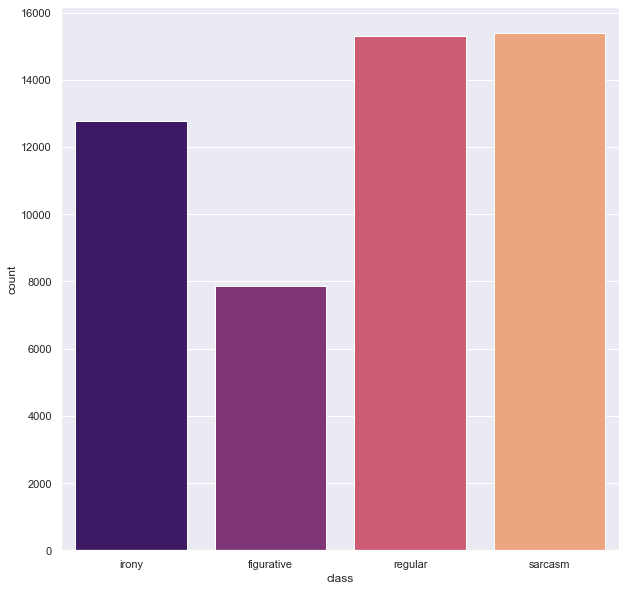

In [51]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['class'], palette = 'magma') 


In [29]:
train_data.head()

,tweets,class,cleaned_text,target
37243,It's not checkers this chess #ironic,irony,checkers chess ironic,0
17599,@DanEwald @LeeCamp Just because the rivers run...,figurative,rivers run dry pockets plus would say h2glow s...,3
57951,@NWPolice School Community Police Officer PC O...,regular,school community police officer pc owen lesson...,2
33550,Can't get any better than listening to a dude ...,irony,cannot get better listening dude mean gingivit...,0
16535,I really love when you ignore me...#myfavorite...,figurative,really love ignore memyfavorite sarcasm,3


C:\Users\Sukrutha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


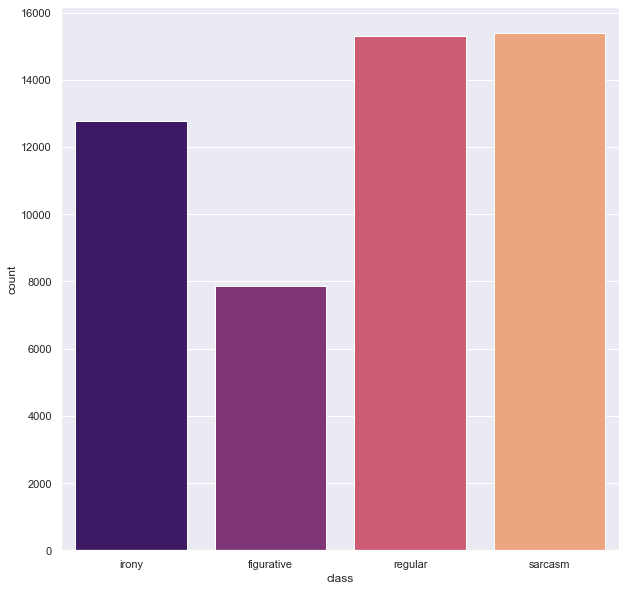

In [52]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['class'], palette = 'magma')
plt.style.use("dark_background")

In [31]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'irony':0,
        'sarcasm':1,
        'regular':2,
        'figurative':3
    }
    return class_dict[t_class]

In [32]:
train_data["target"] = train_data['class'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['class'].apply(lambda x: encode_target(x))

In [33]:
train = train_data[['cleaned_text','target']]
train.columns = ['text','labels']

test = test_data[['cleaned_text','target']]
test.columns = ['text','labels']
train.head()

,text,labels
37243,checkers chess ironic,0
17599,rivers run dry pockets plus would say h2glow s...,3
57951,school community police officer pc owen lesson...,2
33550,cannot get better listening dude mean gingivit...,0
16535,really love ignore memyfavorite sarcasm,3


In [34]:
test.head()

,text,labels
3339,fred jackson lead bills rushing last couple se...,0
4799,augustphotochallenge day29 late snack amazing ...,2
297,persian subtitle one screenshots reads hezboll...,3
3023,tell else winwin situation wanking sink sellin...,0
7692,keep golden ponyboy love intelligence sarcasm,1


In [35]:
traintexts=train['text'].tolist()
testtexts=test['text'].tolist()

all_texts = traintexts + testtexts

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_texts)
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

In [36]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=55000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xtest_tfidf =  tfidf_vect.transform(test['text'])

In [37]:
hash_vectorizer = HashingVectorizer(n_features=55000)
hash_vectorizer.fit(all_texts)
xtrain_hash_vectorizer =  hash_vectorizer.transform(train['text']) 
xtest_hash_vectorizer =  hash_vectorizer.transform(test['text'])

In [38]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

In [39]:
print("NAIVE BAYES CLASSIFIER")
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))
# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

NAIVE BAYES CLASSIFIER
-> Count Vectors Accuracy: 69.43% 
-> WordLevel TF-IDF Accuracy: 68.14%


In [40]:
print("LINEAR CLASSIFIER")
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))
# Linear Classifier on Hash Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

LINEAR CLASSIFIER
-> Count Vectors Accuracy: 63.13999999999999% 
-> WordLevel TF-IDF Accuracy: 74.33999999999999%
-> Hash Vectors Accuracy: 75.0%


In [41]:
print("XGBOOST CLASSIFIER")
# Linear Classifier on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))
# Linear Classifier on Hash Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

XGBOOST CLASSIFIER
-> Count Vectors Accuracy: 75.35% 
-> WordLevel TF-IDF Accuracy: 75.16000000000001%
-> Hash Vectors Accuracy: 75.16000000000001%
